In [ ]:
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Разархивируем папку с патчами 256х256 для города Чикаго. Это патчи от оригинальных снимков и соответствующие им патчи для масок. По этим патчам будем обучать модель.

In [ ]:
!7z x "/content/drive/MyDrive/chicago_patches.7z" -o/content/chicago_data


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 1608607009 bytes (1535 MiB)

Extracting archive: /content/drive/MyDrive/chicago_patches.7z
--
Path = /content/drive/MyDrive/chicago_patches.7z
Type = 7z
Physical Size = 1608607009
Headers Size = 202432
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 3        0% 3 - chicago_patches/images/chicago10_patch_0_0.png                                                         0% 32 - chicago_patches/images/chicago10_patch_10_18.png           

In [ ]:
!pip install -q segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import segmentation_models_pytorch as smp

In [ ]:
# 1. Пути к данным
IMAGE_DIR = '/content/chicago_data/chicago_patches/images'
MASK_DIR = '/content/chicago_data/chicago_patches/masks'

In [ ]:
# 2. Определение класса Dataset
class ChicagoDataset(Dataset):
    def __init__(self, image_filenames, image_dir, mask_dir, transform=None):
        self.image_filenames = image_filenames
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Загрузка изображения
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # В RGB

        # Загрузка маски
        mask_path = os.path.join(self.mask_dir, img_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Бинаризация маски (0 или 1)
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Возвращаем маску с размерностью [1, H, W] для PyTorch
        return image, mask.unsqueeze(0)

In [ ]:
# 3. Настройка трансформаций (Нормализация)
# Используем стандартные значения ImageNet
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Легкая аугментация для обучения
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [ ]:
# 4. Разбиение на выборки
all_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')]

In [ ]:
import random
# 1. Получаем список уникальных имен снимков
all_images = sorted(list(set([f.split('_patch')[0] for f in all_files])))
print('VSE  ',all_images)

# 2. Разбиваем именно оригинальные (их 36) 5000х5000 снимки (например, 31 на
# обучение, 5 на валидацию)
# Итак, обучение будет проведено для 31 снимка по соответствующим патчам.
# Оставшиеся 5 снимков модель в ходе обучения не видела. По этим 5 снимкам из
# валидационного датасета мы проведем анализ качества модели. Для этого мы
# прогоним эти 5 снимков через модель и построим маски-предсказания. Посчитаем
# площадь застройки и сравним с соответствующей площадью для заданных масок.
random.seed(42)
random.shuffle(all_images)
train_img_names = all_images[:31]

val_img_names = all_images[31:]
print('VAL   ',val_img_names)
####################################
# 3. Распределяем патчи по спискам
train_files = [f for f in all_files if f.split('_patch')[0] in train_img_names]
val_files = [f for f in all_files if f.split('_patch')[0] in val_img_names]

print(f"Снимки для обучения: {train_img_names}")
print(f"Снимки для валидации: {val_img_names}")

VSE   ['chicago1', 'chicago10', 'chicago11', 'chicago12', 'chicago13', 'chicago14', 'chicago15', 'chicago16', 'chicago17', 'chicago18', 'chicago19', 'chicago2', 'chicago20', 'chicago21', 'chicago22', 'chicago23', 'chicago24', 'chicago25', 'chicago26', 'chicago27', 'chicago28', 'chicago29', 'chicago3', 'chicago30', 'chicago31', 'chicago32', 'chicago33', 'chicago34', 'chicago35', 'chicago36', 'chicago4', 'chicago5', 'chicago6', 'chicago7', 'chicago8', 'chicago9']
VAL    ['chicago22', 'chicago23', 'chicago25', 'chicago10', 'chicago16']
Снимки для обучения: ['chicago18', 'chicago20', 'chicago14', 'chicago34', 'chicago6', 'chicago27', 'chicago4', 'chicago32', 'chicago3', 'chicago33', 'chicago5', 'chicago19', 'chicago2', 'chicago35', 'chicago17', 'chicago28', 'chicago24', 'chicago9', 'chicago15', 'chicago31', 'chicago1', 'chicago8', 'chicago21', 'chicago26', 'chicago11', 'chicago7', 'chicago36', 'chicago29', 'chicago12', 'chicago30', 'chicago13']
Снимки для валидации: ['chicago22', 'chicago2

In [ ]:
print(f"Всего патчей: {len(all_files)}")
print(f"Обучение: {len(train_files)}")
print(f"Валидация: {len(val_files)}")

Всего патчей: 11307
Обучение: 9657
Валидация: 1650


In [ ]:
# 5. Создание объектов Dataset и DataLoader
train_dataset = ChicagoDataset(train_files, IMAGE_DIR, MASK_DIR, transform=train_transform)
val_dataset = ChicagoDataset(val_files, IMAGE_DIR, MASK_DIR, transform=val_transform)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
# 6. Проверка
image, mask = next(iter(train_loader))
print(f"Размер батча изображений: {image.shape}")
print(f"Размер батча масок: {mask.shape}")

Размер батча изображений: torch.Size([32, 3, 256, 256])
Размер батча масок: torch.Size([32, 1, 256, 256])


**Комбинированный LOSS - BCEWithLogitsLoss+DiceLoss**

In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        # BCE с автоматическим применением Sigmoid для стабильности
        self.bce = nn.BCEWithLogitsLoss()

        # Dice Loss из библиотеки smp
        self.dice = smp.losses.DiceLoss(mode='binary', from_logits=True)

        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def forward(self, logits, targets):
        # targets должны иметь тот же тип, что и logits (float)
        targets = targets.float()

        loss_bce = self.bce(logits, targets)
        loss_dice = self.dice(logits, targets)

        # Итоговая сумма с весами
        total_loss = (self.bce_weight * loss_bce) + (self.dice_weight * loss_dice)
        return total_loss

Создаем модель по типу Unet.

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        skip = self.conv(x)
        down = self.pool(skip)
        return skip, down

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1) # Склеиваем по каналам
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        # Энкодер
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        # Центр (Bottleneck)
        self.bottleneck = DoubleConv(512, 1024)

        # Декодер
        # Теперь передаем: сколько каналов НА ВХОДЕ в апсэмпл и сколько НА ВЫХОДЕ из всего блока
        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        sk1, x = self.down1(x)
        sk2, x = self.down2(x)
        sk3, x = self.down3(x)
        sk4, x = self.down4(x)

        x = self.bottleneck(x)

        x = self.up1(x, sk4)
        x = self.up2(x, sk3)
        x = self.up3(x, sk2)
        x = self.up4(x, sk1)

        return self.out(x)

In [ ]:
from tqdm.notebook import tqdm
def train_single_epoch(model, optimizer, criterion, train_dataloader, device,loss_type):
    model.train()
    nnn=0
    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch.to(torch.float))

        loss.backward()  # backward-pass
        optimizer.step()  # update weights
        optimizer.zero_grad() # set parameter gradients to zero

        avg_loss += loss.item()

    avg_loss = avg_loss/len(train_dataloader)

    return avg_loss

Отрисовка оригинального снимка, маски и предсказания.

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(model, dataloader, device, epoch, num_samples=3):
    model.eval()
    # Берем один батч из валидатора
    images, masks = next(iter(dataloader))

    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        logits = model(images)
        preds = torch.sigmoid(logits) > 0.5  # Бинаризация предсказания

    # Переводим в numpy для отрисовки
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Стандартные значения денормировки (ImageNet)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(12, 12))
    plt.suptitle(f'Epoch {epoch} - Visualization', fontsize=16)

    for i in range(num_samples):
        # 1. Оригинальное фото (Денормировка)
        img = images[i] * std + mean
        img = np.clip(img, 0, 1)  # Обрезаем лишнее, чтобы не было ошибок

        # 2. Истинная маска
        gt = masks[i][0]

        # 3. Предсказание модели
        pred = preds[i][0]

        # Ряд i, Колонка 1: Оригинал
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Original Photo")
        plt.axis('off')

        # Ряд i, Колонка 2: Маска (Ground Truth)
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(gt, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        # Ряд i, Колонка 3: Предсказание
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Model Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
  #  plt.savefig(f'epoch_{epoch}.png')

Цикл обучения.

In [ ]:
def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device,loss_type, plot_every=5):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(1,epochs)):

        train_loss = train_single_epoch(model, optimizer, criterion, train_dataloader, device,loss_type)
        total_train_loss.append(train_loss)

        print(f'Epoch {epoch}: train loss = {train_loss}')

        # ВИЗУАЛИЗАЦИЯ: каждые plot_every эпох
        if epoch == 0 or (epoch) % plot_every == 0:
            visualize_results(model, valid_dataloader, device, epoch , num_samples=3)
            # Переключаем модель обратно в режим обучения после валидации/визуализации
            model.train()

        if (epoch) % 5 == 0:
            checkpoint_path = f"/content/drive/MyDrive/checkpoint_epoch_{epoch}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"--- Модель сохранена в {checkpoint_path} ---")

    return model, total_train_loss

In [ ]:
# 1. Определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(f"Using device: {device}")

# 2. Создаем модель и сразу отправляем на устройство
model = UNet().to(device)

Using device: cuda


In [ ]:
#3. Загружаем чекпоинт если продолжаем обучение

checkpoint = torch.load(f"/content/drive/MyDrive/checkpoint_epoch_125.pth", map_location=device)
model.load_state_dict(checkpoint)
print("Модель загружена.")

Модель загружена.


In [ ]:
# 4. Настраиваем лосс и оптимизатор
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 5. Остальные параметры
loss_type = 1
epochs = 150

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 126: train loss = 0.06673705560580784


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 127: train loss = 0.06454611952040369


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 128: train loss = 0.0635335175258829


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 129: train loss = 0.06309299526230389


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 130: train loss = 0.062207233900858076


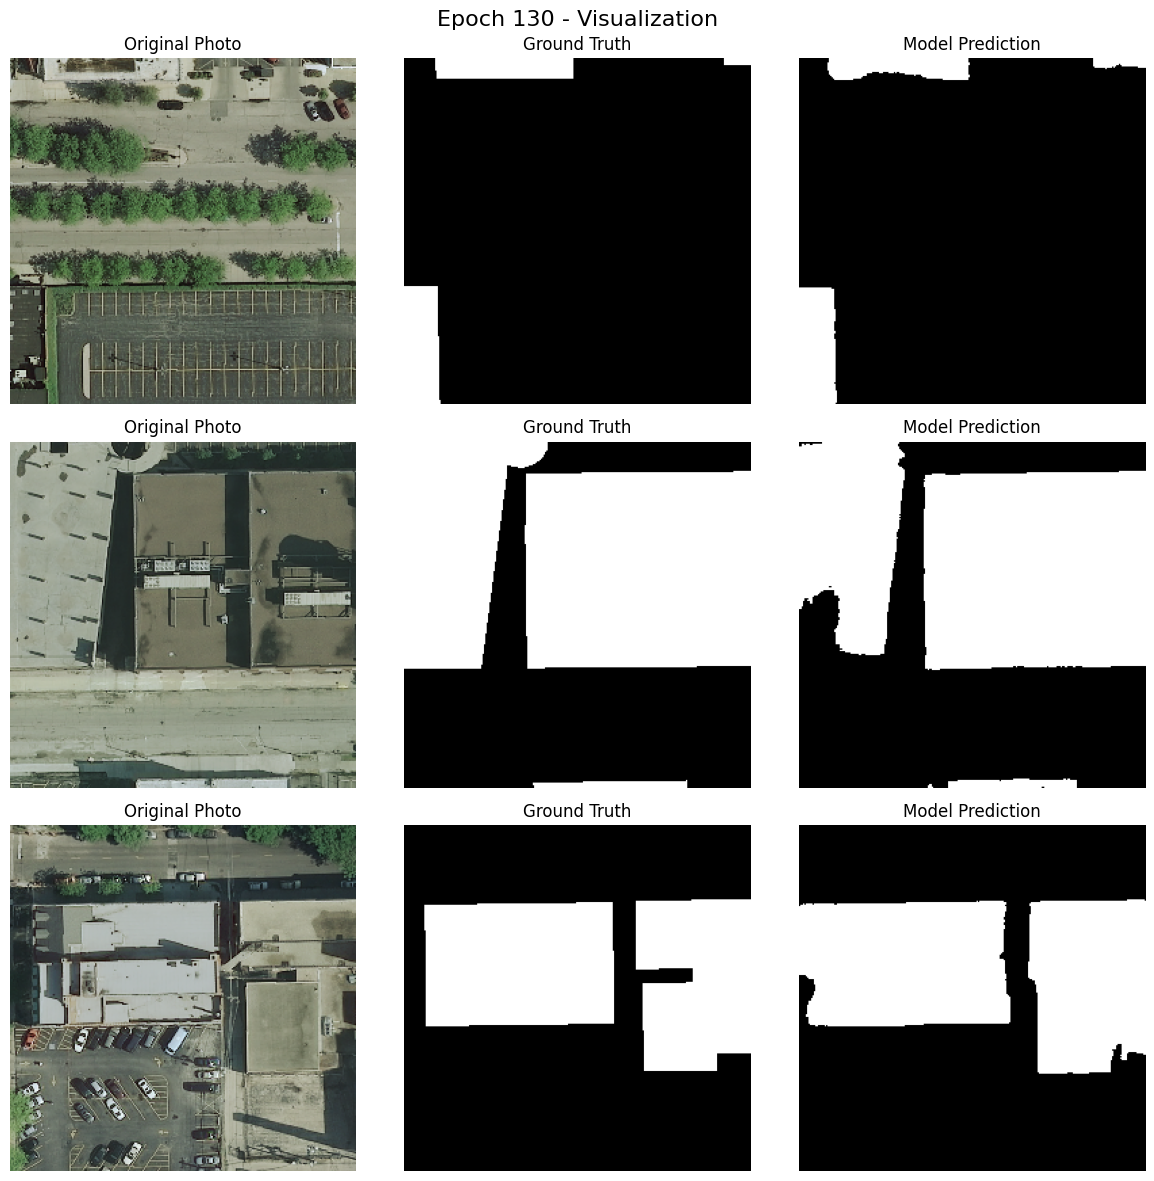

--- Модель сохранена в /content/drive/MyDrive/checkpoint_epoch_130.pth ---


  0%|          | 0/302 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model, statisticsSEGNET = train(model, optimizer, criterion, epochs, train_loader, val_loader, device,loss_type,5)